<a href="https://colab.research.google.com/github/amishra06/Club-Mahindra-DataOlympics/blob/master/club_mahindra_fnb_spend_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai import *
from fastai.basics import *
from fastai.tabular import *

In [3]:
#pwd()

'/content'

In [0]:
#I am working on google colab
path = '/content'

In [0]:
table_names = ['train', 'test']

In [0]:
tables = [pd.read_csv(f'{fname}.csv', low_memory=False) for fname in table_names]

In [0]:
train_df,test_df = tables

In [8]:
len(train_df),len(test_df)

(341424, 146765)

In [0]:
#Trying to understand the data
#train_df.describe()
#train_df.head().T
#train_df.nunique()
#One of the roomnights is -45. Needs to be  inestigated.  
#train_df[train_df['roomnights'] == -45].T
#train_df['roomnights'].unique()

**Simple Feature Engineering**

In [0]:
# from columns 'checking_date' and 'checkout_date' creating new field 'roomdays' 
import time
from datetime import datetime as dt

def get_roomdays(df,fld1,fld2,fld3):
    adiff = []
    for date1, date2 in zip(df[fld1],df[fld2]):
        diff = dt.strptime(date2, "%d/%m/%y") - dt.strptime(date1, "%d/%m/%y")
        adiff.append(int(diff.days))
    df[fld3] = pd.Series(adiff)

In [0]:
get_roomdays(train_df, 'checkin_date', 'checkout_date', 'roomdays' )


In [0]:
get_roomdays(test_df, 'checkin_date', 'checkout_date', 'roomdays' )


In [0]:
#Setting roomnights where its -45 as a day less than roomdays

train_df.loc[train_df.roomnights == -45, 'roomnights'] = 6


**Data Processing**

In [0]:
# Processing to be done on data. FillMissing will look for missing values and handle them in some way. Categorify will turn categorical 
# variables in pandas categories. Normalize will normalize continuous variables.
procs=[FillMissing, Categorify, Normalize]

In [0]:
# Defining categorical and continuous variables

cat_vars = ['channel_code', 'main_product_code', 'numberofadults', 'numberofchildren', 'persontravellingid', 'resort_region_code', 
            'resort_type_code', 'room_type_booked_code', 'roomnights', 'state_code_resort', 'total_pax', 'booking_type_code','cluster_code',
            'reservationstatusid_code','member_age_buckets', 'roomdays']

cont_vars = ['season_holidayed_code', 'state_code_residence']



In [0]:
# Defining dependent variable and creating dataframe consisting of categorical, contnuous and dependent variables
dep_var = 'amount_spent_per_room_night_scaled'
df = train_df[cat_vars + cont_vars + [dep_var]].copy()


In [0]:
# Defining validation range
valid_idx = range(len(df)-20000, len(df))

In [18]:
valid_idx

range(321424, 341424)

In [19]:
train_df.amount_spent_per_room_night_scaled.head()


0    7.706428
1    6.662563
2    7.871602
3    5.344943
4    7.059346
Name: amount_spent_per_room_night_scaled, dtype: float64

**Model Creation**

In [0]:
# Create databunch to be used in deep learning model
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
        .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

In [0]:
# Set the y range
max_y = np.max(train_df['amount_spent_per_room_night_scaled'])*1.2
y_range = torch.tensor([0, max_y], device=defaults.device)

In [0]:
# Set the deep learning neural net with no of layers and other regularisation parameters
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [0]:
learn.model

In [25]:
len(data.train_ds.cont_names)

2

**Training the model**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


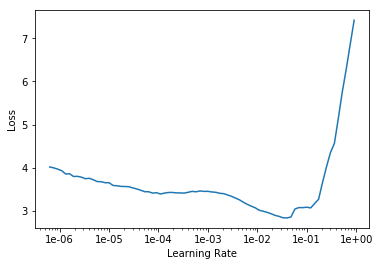

In [26]:
# Find suitable learning rate
learn.lr_find()
learn.recorder.plot()

In [27]:
# Train for 5 epochs with learning rate we found above
learn.fit_one_cycle(5, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.968730,1.163052,1.070445,03:02
1,1.042516,1.184946,1.080636,03:33
2,1.042422,1.166096,1.071410,03:54
3,0.969297,1.131464,1.054419,04:31
4,0.950972,1.131354,1.054901,06:44


In [0]:
# Save the trained model
learn.save('1')

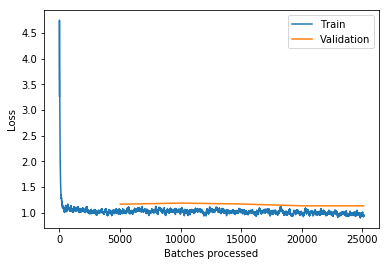

In [29]:
# Plot train and validation loss
learn.recorder.plot_losses()

In [0]:
# Load the previously trained model and train it further
learn.load('1');

In [32]:
# train for 5 epochs
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.973087,1.135737,1.057299,07:52
1,0.983895,1.136422,1.057577,07:50
2,0.993413,1.130939,1.054917,07:49
3,0.948228,1.136380,1.057767,07:49
4,0.953245,1.133956,1.056460,07:49


In [0]:
learn.save('2')

In [0]:
#learn.load('2');

**Prediction on Test set**

In [0]:
# Creation of submission file from test set prediction values
test_preds=learn.get_preds(DatasetType.Test)
test_df["amount_spent_per_room_night_scaled"]=test_preds[0].data.numpy().T[0]
test_df["amount_spent_per_room_night_scaled"]=test_df["amount_spent_per_room_night_scaled"].astype("float")
test_df[["reservation_id","amount_spent_per_room_night_scaled"]].to_csv("submission.csv",index=False)